<a href="https://colab.research.google.com/github/yiit8/My-Custom-Backbone-Model-for-Car-Detection/blob/main/Car_Truck_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
!pip install torch

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/MyDrive/Vehicle datasets/Vehicle_datasets.zip" -d "/content/Vehicle dataset"
!unzip "/content/Vehicle dataset/Vehicle_classification.zip" -d "/content/Vehicle dataset"


In [3]:
# Kutuphaneler


import shutil
from __future__ import print_function, division
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

In [4]:
# Veri arttirim kismi

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [5]:
import shutil

# Validation ve train setleri iyi dagilmadigi icin topluyoruz

src_dir = '/content/Vehicle dataset/valid/Car'
dst_dir = '/content/Vehicle dataset/train/Car'

for file in os.listdir(src_dir):
  src_file = os.path.join(src_dir, file)
  dst_file = os.path.join(dst_dir, file)
  shutil.move(src_file, dst_file)




src_dir1 = '/content/Vehicle dataset/valid/Truck'
dst_dir1 = '/content/Vehicle dataset/train/Truck'

for file in os.listdir(src_dir1):
  src_file1 = os.path.join(src_dir1, file)
  dst_file1 = os.path.join(dst_dir1, file)
  shutil.move(src_file1, dst_file1)



In [6]:
from sklearn.model_selection import train_test_split
import glob

# Car ve Truck verilerini %80 - 20 seklinde dagitiyoruz
car_paths = glob.glob("/content/Vehicle dataset/train/Car/*")


car_train_paths, car_val_paths = train_test_split(car_paths, test_size=0.2)


truck_paths = glob.glob("/content/Vehicle dataset/train/Truck/*")


truck_train_paths, truck_val_paths = train_test_split(truck_paths, test_size=0.2)




print("Number of training examples for Car:", len(car_train_paths))
print("Number of validation examples for Car:", len(car_val_paths))
print("Number of training examples for Truck:", len(truck_train_paths))
print("Number of validation examples for Truck:", len(truck_val_paths))


Number of training examples for Car: 4706
Number of validation examples for Car: 1177
Number of training examples for Truck: 3428
Number of validation examples for Truck: 857


In [7]:


# Islem kolayligi icin dagittigimiz verileri validation dosyasina yolluyoruz

for path in car_val_paths:
  shutil.move(path, "/content/Vehicle dataset/valid/Car")


for path in truck_val_paths:
  shutil.move(path, "/content/Vehicle dataset/valid/Truck")

In [8]:
data_dir = '/content/Vehicle dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
image_datasets

In [9]:
dataset_sizes

{'train': 8134, 'valid': 2034}

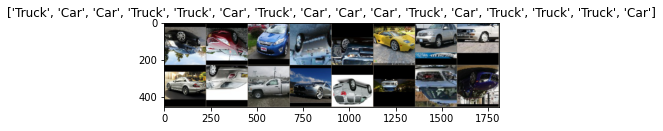

In [10]:
# Veri gorsellestirmesi

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Egitim verisinden bir grup veri edindik
inputs, classes = next(iter(dataloaders['train']))

# Veri grubundan grid olusturduk
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
# Model egitimi



def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
     
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_values = []
    train_accuracy_values = []
    val_loss_values = []
    val_accuracy_values = []
    
    

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Her bir epoch egitim ve dogrulama asamasina sahip
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Modeli egitim moduna al
            else:
                model.eval()   # Degerlendirme modu

            running_loss = 0.0
            running_corrects = 0

            # Veri uzerinde iterasyon.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Parametre gradyanlarının sifirlanmasi
                optimizer.zero_grad()

                # ileri yayilim
                # egitim asamasindaysa durumu gozle
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # egitim asamasinda geri dagilim + optimizasyon
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

  

                # istatistikler
                correct = torch.eq(preds, labels).sum()
                running_corrects += correct
                running_loss += loss.item() * inputs.size(0)


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

          


            # deep copy
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    
    # Train - val kayip fonksiyonu ve isabetliligini takip etme

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    ax1.plot(train_loss_values, 'bo-', label='Train Loss')
    ax1.plot(val_loss_values, 'ro-', label='Val Loss')
    ax1.legend()
    ax2.plot(train_accuracy_values, 'bo-', label='Train Accuracy')
    ax2.plot(val_accuracy_values, 'ro-', label='Val Accuracy')
    ax2.legend()
    plt.show()

    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model






In [13]:
# Tahminlerin gorsellestirilmesi

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Sinif sayimiz Car ve Truck olmak uzere 2'dir

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Stokastik gd kullandik
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# her 7 epochtan sonra 0.1 buyuklukte learning rate decay saglandi
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/19
----------


100%|██████████| 509/509 [00:31<00:00, 16.41it/s]


train Loss: 0.4239 Acc: 0.7932


100%|██████████| 128/128 [00:02<00:00, 50.23it/s]


valid Loss: 0.1699 Acc: 0.9292

Epoch 1/19
----------


100%|██████████| 509/509 [00:22<00:00, 22.54it/s]


train Loss: 0.2929 Acc: 0.8715


100%|██████████| 128/128 [00:02<00:00, 51.08it/s]


valid Loss: 0.2177 Acc: 0.9194

Epoch 2/19
----------


100%|██████████| 509/509 [00:22<00:00, 22.90it/s]


train Loss: 0.2402 Acc: 0.8976


100%|██████████| 128/128 [00:02<00:00, 51.66it/s]


valid Loss: 0.0889 Acc: 0.9617

Epoch 3/19
----------


100%|██████████| 509/509 [00:22<00:00, 22.83it/s]


train Loss: 0.2273 Acc: 0.9025


100%|██████████| 128/128 [00:02<00:00, 51.31it/s]


valid Loss: 0.1624 Acc: 0.9351

Epoch 4/19
----------


100%|██████████| 509/509 [00:22<00:00, 22.88it/s]


train Loss: 0.1995 Acc: 0.9169


100%|██████████| 128/128 [00:02<00:00, 52.23it/s]


valid Loss: 0.0716 Acc: 0.9700

Epoch 5/19
----------


100%|██████████| 509/509 [00:21<00:00, 23.19it/s]


train Loss: 0.1741 Acc: 0.9292


100%|██████████| 128/128 [00:02<00:00, 51.92it/s]


valid Loss: 0.0564 Acc: 0.9769

Epoch 6/19
----------


100%|██████████| 509/509 [00:22<00:00, 23.10it/s]


train Loss: 0.1716 Acc: 0.9287


100%|██████████| 128/128 [00:02<00:00, 50.55it/s]


valid Loss: 0.0518 Acc: 0.9798

Epoch 7/19
----------


100%|██████████| 509/509 [00:21<00:00, 23.15it/s]


train Loss: 0.1508 Acc: 0.9396


100%|██████████| 128/128 [00:02<00:00, 51.08it/s]


valid Loss: 0.0423 Acc: 0.9867

Epoch 8/19
----------


100%|██████████| 509/509 [00:22<00:00, 22.98it/s]


train Loss: 0.1385 Acc: 0.9412


100%|██████████| 128/128 [00:02<00:00, 52.56it/s]


valid Loss: 0.0375 Acc: 0.9882

Epoch 9/19
----------


100%|██████████| 509/509 [00:22<00:00, 22.97it/s]


train Loss: 0.1273 Acc: 0.9446


100%|██████████| 128/128 [00:02<00:00, 51.54it/s]


valid Loss: 0.0368 Acc: 0.9862

Epoch 10/19
----------


100%|██████████| 509/509 [00:22<00:00, 22.90it/s]


train Loss: 0.1231 Acc: 0.9463


100%|██████████| 128/128 [00:02<00:00, 50.45it/s]


valid Loss: 0.0350 Acc: 0.9867

Epoch 11/19
----------


100%|██████████| 509/509 [00:22<00:00, 22.74it/s]


train Loss: 0.1145 Acc: 0.9523


100%|██████████| 128/128 [00:02<00:00, 51.11it/s]


valid Loss: 0.0352 Acc: 0.9877

Epoch 12/19
----------


100%|██████████| 509/509 [00:22<00:00, 22.88it/s]


train Loss: 0.1188 Acc: 0.9509


100%|██████████| 128/128 [00:02<00:00, 50.65it/s]


valid Loss: 0.0327 Acc: 0.9892

Epoch 13/19
----------


100%|██████████| 509/509 [00:22<00:00, 22.99it/s]


train Loss: 0.1137 Acc: 0.9508


100%|██████████| 128/128 [00:02<00:00, 51.30it/s]


valid Loss: 0.0346 Acc: 0.9862

Epoch 14/19
----------


100%|██████████| 509/509 [00:22<00:00, 22.86it/s]


train Loss: 0.1197 Acc: 0.9511


100%|██████████| 128/128 [00:02<00:00, 51.59it/s]


valid Loss: 0.0322 Acc: 0.9907

Epoch 15/19
----------


100%|██████████| 509/509 [00:22<00:00, 22.99it/s]


train Loss: 0.1115 Acc: 0.9555


100%|██████████| 128/128 [00:02<00:00, 50.96it/s]


valid Loss: 0.0320 Acc: 0.9882

Epoch 16/19
----------


100%|██████████| 509/509 [00:22<00:00, 23.04it/s]


train Loss: 0.1158 Acc: 0.9487


100%|██████████| 128/128 [00:02<00:00, 50.50it/s]


valid Loss: 0.0316 Acc: 0.9887

Epoch 17/19
----------


100%|██████████| 509/509 [00:22<00:00, 23.01it/s]


train Loss: 0.1193 Acc: 0.9540


100%|██████████| 128/128 [00:02<00:00, 51.06it/s]


valid Loss: 0.0321 Acc: 0.9902

Epoch 18/19
----------


100%|██████████| 509/509 [00:22<00:00, 23.03it/s]


train Loss: 0.1144 Acc: 0.9507


100%|██████████| 128/128 [00:02<00:00, 50.44it/s]


valid Loss: 0.0322 Acc: 0.9887

Epoch 19/19
----------


100%|██████████| 509/509 [00:21<00:00, 23.15it/s]


train Loss: 0.1165 Acc: 0.9519


100%|██████████| 128/128 [00:02<00:00, 51.09it/s]


valid Loss: 0.0321 Acc: 0.9892



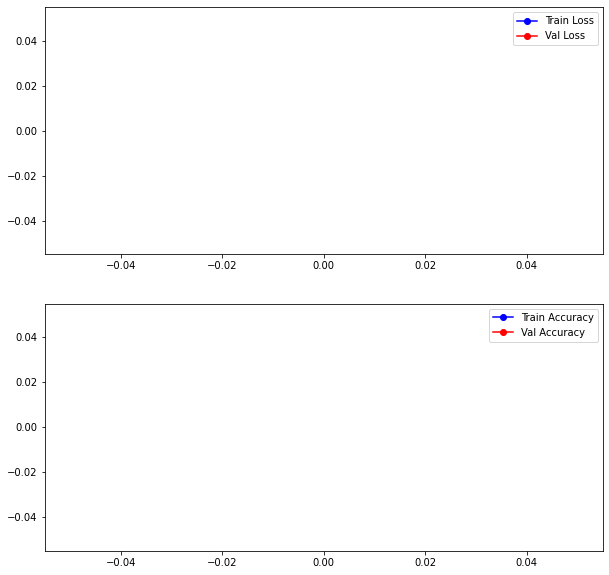

Training complete in 8m 23s
Best val Acc: 0.990659


In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

In [ ]:
!nvidia-smi

In [ ]:
print(model_ft)

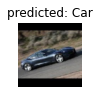

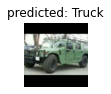

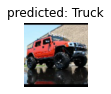

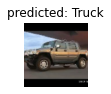

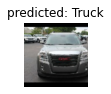

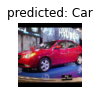

In [17]:
visualize_model(model_ft)

In [21]:
# agirliklar icin

torch.save(model_ft.state_dict(), "CarClassifierWeights.pt")

# tum model icin

torch.save(model_ft, "CarClassifierWholeModel.pt")